# COMP 4531 Final Project - Winter 2024

Team: Corey Munk and Kurt Meyer

Topic: Image Classification with the CIFAR-100 data set


The problem is well understood. In your final project, please utilize some pre-built models. While they are generally large and accurate, they should be used to establish the upper bound of performance. Then, demonstrate the detailed steps you took to develop your own model. Of course, using a random classifier to set a baseline is not meaningful.




# Load Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings('default')

import csv
import json
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l1, l2

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Load Data

In [2]:
# Load CIFAR-100 data  https://www.cs.toronto.edu/%7Ekriz/cifar.html
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine') #Each image has a "fine" label (class) and a "coarse" label (superclass).

# normalize pixel values
x_train, x_test = x_train/255, x_test/255

y_train_raw = y_train.copy()

#one hot encode labels
y_train = to_categorical(y_train, num_classes=100)
y_test = to_categorical(y_test, num_classes=100)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 100)
(10000, 32, 32, 3)
(10000, 100)


## EDA and Data Handling

In [4]:
# Define label names for fine and coarse levels

fine_names = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin',
    'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 
    'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck',
    'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew',
    'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 
    'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

coarse_names = [
    'fruit and vegetables', 'fish', 'people', 'large carnivores', 'aquatic mammals', 'household furniture', 'insects', 'insects', 'vehicles 1',
    'food containers', 'food containers', 'people', 'large man-made outdoor things', 'vehicles 1', 'insects', 'large omnivores and herbivores', 
    'food containers', 'large man-made outdoor things', 'insects', 'large omnivores and herbivores', 'household furniture', 
    'large omnivores and herbivores', 'household electrical device', 'large natural outdoor scenes', 'insects', 'household furniture', 
    'non-insect invertebrates', 'reptiles', 'food containers', 'reptiles', 'aquatic mammals', 'large omnivores and herbivores', 'fish', 
    'large natural outdoor scenes', 'medium-sized mammals', 'people', 'small mammals', 'large man-made outdoor things', 'large omnivores and herbivores', 
    'household electrical device', 'household electrical device', 'vehicles 2', 'large carnivores', 'large carnivores', 'reptiles', 
    'non-insect invertebrates', 'people', 'trees', 'vehicles 1', 'large natural outdoor scenes', 'small mammals', 'fruit and vegetables', 'trees', 
    'fruit and vegetables', 'flowers', 'aquatic mammals', 'trees', 'fruit and vegetables', 'vehicles 1', 'trees', 'large natural outdoor scenes', 
    'food containers', 'flowers', 'medium-sized mammals', 'medium-sized mammals', 'small mammals', 'medium-sized mammals', 'fish', 
    'large man-made outdoor things', 'vehicles 2', 'flowers', 'large natural outdoor scenes', 'aquatic mammals', 'fish', 'small mammals', 
    'medium-sized mammals', 'large man-made outdoor things', 'non-insect invertebrates', 'reptiles', 'non-insect invertebrates', 'small mammals', 
    'vehicles 2', 'flowers', 'fruit and vegetables', 'household furniture', 'vehicles 2', 'household electrical device', 'household electrical device', 
    'large carnivores', 'vehicles 2', 'vehicles 1', 'fish', 'flowers', 'reptiles', 'household furniture', 'aquatic mammals', 'trees', 'large carnivores', 
    'people', 'non-insect invertebrates'
]

# mapping_coarse_fine = {
#                    'aquatic mammals': ['beaver', 'dolphin', 'otter', 'seal', 'whale'],
#                               'fish': ['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout'],
#                            'flowers': ['orchid', 'poppy', 'rose', 'sunflower', 'tulip'],
#                    'food containers': ['bottle', 'bowl', 'can', 'cup', 'plate'],
#               'fruit and vegetables': ['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper'],
#        'household electrical device': ['clock', 'computer_keyboard', 'lamp', 'telephone', 'television'],
#                'household furniture': ['bed', 'chair', 'couch', 'table', 'wardrobe'],
#                            'insects': ['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'],
#                   'large carnivores': ['bear', 'leopard', 'lion', 'tiger', 'wolf'],
#      'large man-made outdoor things': ['bridge', 'castle', 'house', 'road', 'skyscraper'],
#       'large natural outdoor scenes': ['cloud', 'forest', 'mountain', 'plain', 'sea'],
#     'large omnivores and herbivores': ['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo'],
#               'medium-sized mammals': ['fox', 'porcupine', 'possum', 'raccoon', 'skunk'],
#           'non-insect invertebrates': ['crab', 'lobster', 'snail', 'spider', 'worm'],
#                             'people': ['baby', 'boy', 'girl', 'man', 'woman'],
#                           'reptiles': ['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle'],
#                      'small mammals': ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'],
#                              'trees': ['maple_tree', 'oak_tree', 'palm_tree', 'pine_tree', 'willow_tree'],
#                         'vehicles 1': ['bicycle', 'bus', 'motorcycle', 'pickup_truck', 'train'],
#                         'vehicles 2': ['lawn_mower', 'rocket', 'streetcar', 'tank', 'tractor'],
# }

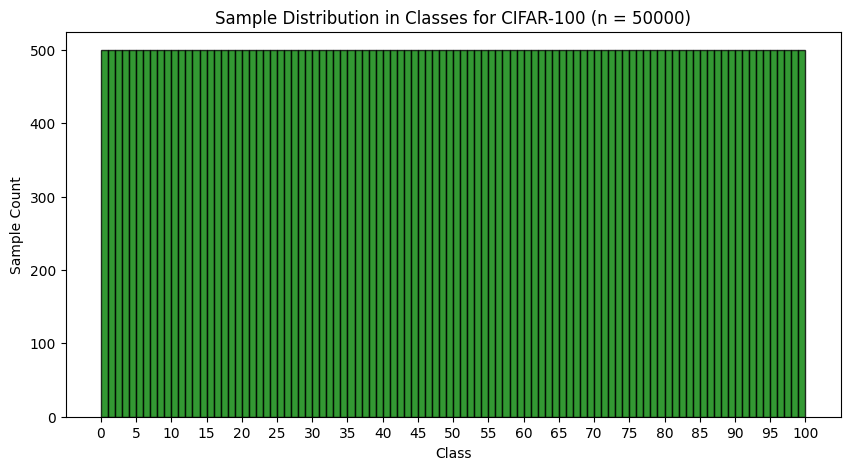

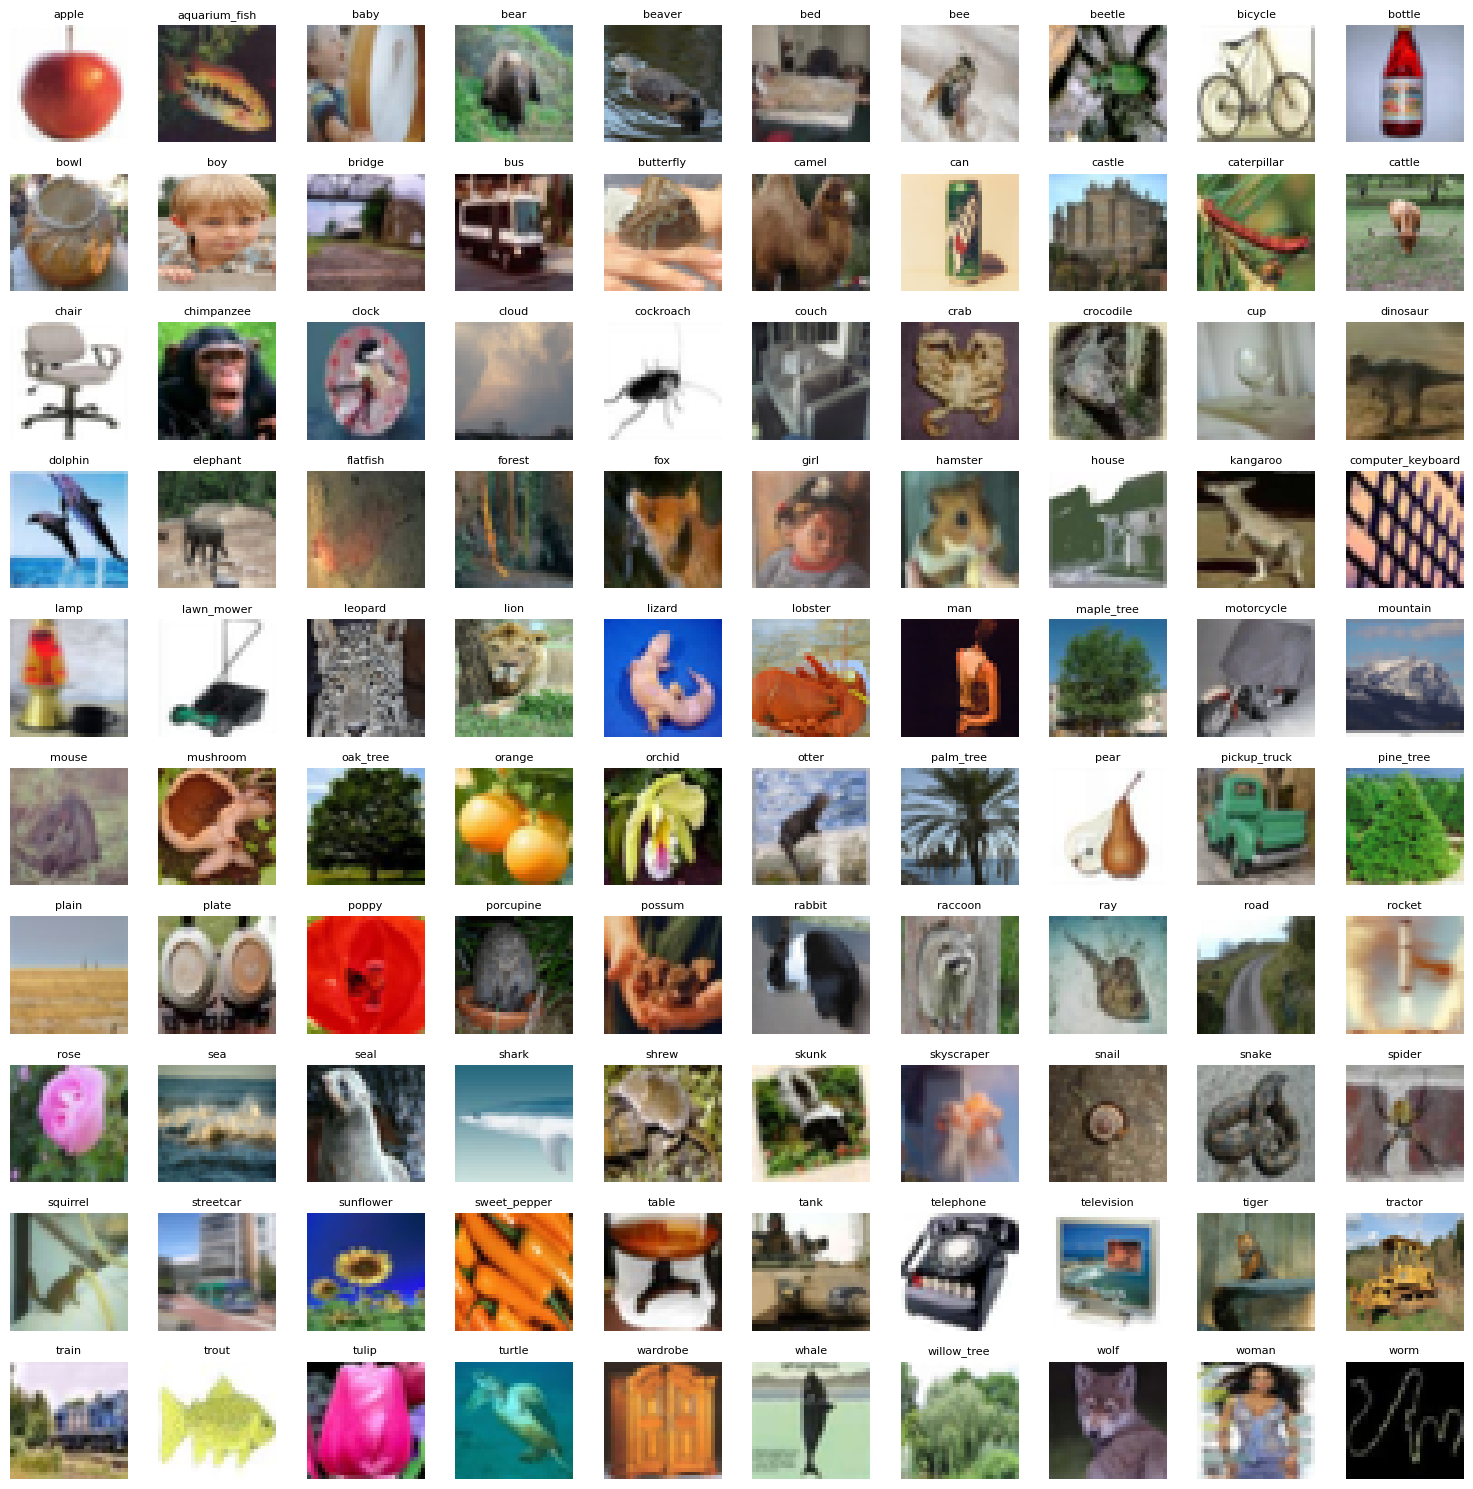

In [5]:
# Show sample count by label to visualize the balance of the data
class_labels = y_train_raw.flatten()

plt.figure(figsize=(10,5))
plt.hist(class_labels, bins=np.arange(0,101), alpha=.8, color='green', edgecolor='black')
plt.title(f'Sample Distribution in Classes for CIFAR-100 (n = {len(class_labels)})')
plt.xlabel('Class')
plt.ylabel('Sample Count')
plt.xticks(np.arange(0,101, step=5))
plt.show()

# Display an image from each class in the dataset
distinct_labels = np.unique(y_train_raw)
fig, axes = plt.subplots(10, 10, figsize=(15, 15))

for i, label in enumerate(distinct_labels):
    # Get image and label
    idx = np.where(y_train_raw == label)[0]
    random_index = np.random.choice(idx)
    image, label = x_train[random_index], y_train_raw[random_index][0]
    
    # Define grid cell to place image
    row = i // 10
    col = i % 10
    
    # Display image in defined grid cell
    current_image = (image.reshape((32, 32, 3)) * 255).clip(0, 255).astype(int)
    axes[row, col].imshow(current_image, interpolation='nearest')
    
    # Get fine name for the label
    fine_name = fine_names[label]
    
    axes[row, col].set_title(f"{fine_name}", fontsize=8)  # Use fine_name for the title
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [9]:
def model_performance(history):
        # Plots
        plt.figure(figsize=(20, 4))

        # plot accuracy
        plt.subplot(1, 3, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.ylim(0, 1)
        plt.legend()

        # plot loss
        plt.subplot(1, 3, 2)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # plot learning rate changes
        plt.subplot(1, 3, 3)
        plt.plot(history.history['lr'], label='Learning Rate')
        plt.xlabel('Epochs')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate Changes')
        plt.legend()

        plt.tight_layout()
        plt.show()

        # Training Data
        final_train_accuracy = history.history['accuracy'][-1]
        final_train_loss = history.history['loss'][-1]
        print('Training Performance:')
        print(f"Accuracy: {round(final_train_accuracy*100, 2)}%")
        print(f"Loss: {round(final_train_loss, 4)}")

        # Validation Data
        final_val_accuracy = history.history['val_accuracy'][-1]
        final_val_loss = history.history['val_loss'][-1]
        print('\nValidation Performance:')
        print(f"Accuracy: {round(final_val_accuracy*100, 2)}%")
        print(f"Loss: {round(final_val_loss, 4)}")

# model_performance(hist)

In [8]:
def save_model_info(model, model_id, optimizer, loss, filters, dropout_rate, kernel_size, pool_size, dense_units, history):
    model_id = model_id

    # Save model architecture to CSV
    with open('model_architecture.csv', 'a', newline='') as csvfile:
        fieldnames_architecture = ['model_id', 'architecture', 'config']
        writer_architecture = csv.DictWriter(csvfile, fieldnames=fieldnames_architecture)

        # Write headers if the file is empty
        if csvfile.tell() == 0:
            writer_architecture.writeheader()

        optimizer_config = optimizer.get_config()
        config = f"op: {optimizer_config['name']}, learning_rate: {optimizer_config['learning_rate']}, " \
                 f"l: {loss}, fltr: {filters}, dor: {dropout_rate}, ks: {kernel_size}, " \
                 f"ps: {pool_size}, du: {dense_units}"

        writer_architecture.writerow({
            'model_id': model_id,
            'architecture': model.to_json(),  # Save model architecture as JSON string
            'config': config
        })

    # Save model performance to CSV
    with open('model_performance.csv', 'a', newline='') as csvfile:
        fieldnames_performance = ['model_id', 'epoch', 'accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate']
        writer_performance = csv.DictWriter(csvfile, fieldnames=fieldnames_performance)

        # Write headers if the file is empty
        if csvfile.tell() == 0:
            writer_performance.writeheader()

        for epoch in range(1, len(history.history['accuracy']) + 1):
            writer_performance.writerow({
                'model_id': model_id,
                'epoch': epoch,
                'accuracy': history.history['accuracy'][epoch - 1],
                'loss': history.history['loss'][epoch - 1],
                'val_accuracy': history.history['val_accuracy'][epoch - 1],
                'val_loss': history.history['val_loss'][epoch - 1],
                'learning_rate': history.history.get('lr', [None])[epoch - 1]
            })


## Augmentation

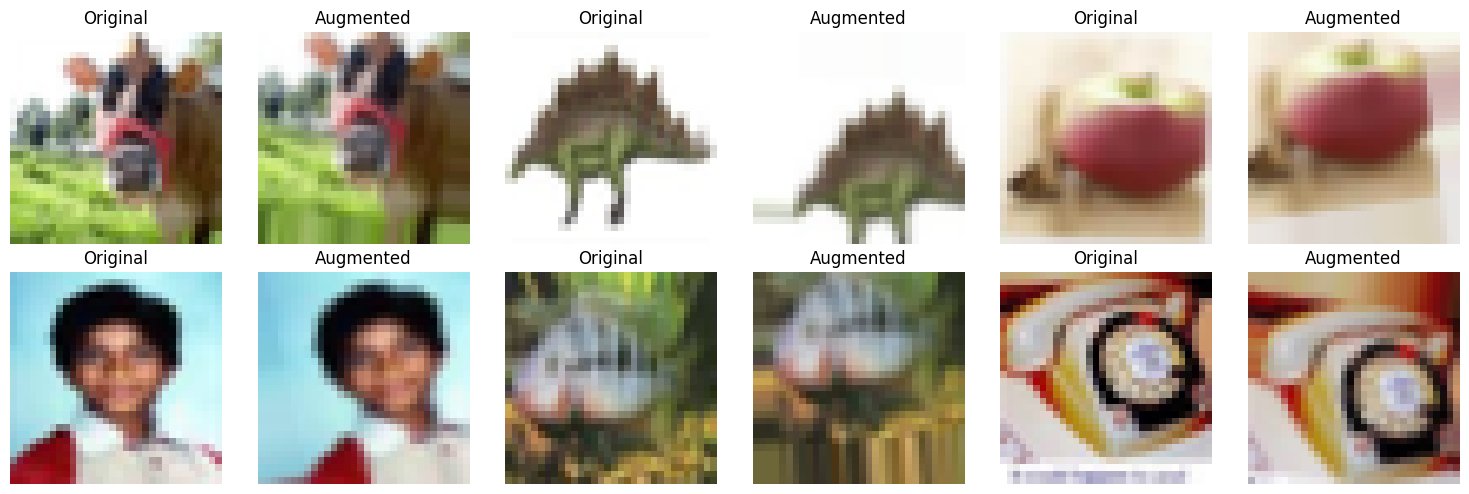

In [10]:
# Create an ImageDataGenerator with data augmentation
datagen = ImageDataGenerator(
    # featurewise_center=True,
    # samplewise_center=True,
    # featurewise_std_normalization=True,
    # samplewise_std_normalization=True,
    # zca_whitening=True,
    # zca_epsilon=1e-06,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    # brightness_range=None,
    shear_range=0.2,
    # zoom_range=0.2,
    # channel_shift_range=0.3,
    # fill_mode='nearest',
    # cval=0.0,
    # horizontal_flip=True,
    # vertical_flip=True,
    # rescale=None,
    # preprocessing_function=None,
    # data_format=None,
    # validation_split=0.0,
    # interpolation_order=1,
    # dtype=None
)

# Get a batch of augmented images
num_images = 6
augmented_images, labels = next(datagen.flow(x_train, y_train, batch_size=num_images, shuffle=False))

# Plot the original and augmented images side by side
plt.figure(figsize=(15, 5))
for i in range(num_images):
    # Plot original image
    plt.subplot(2, num_images, i * 2 + 1)
    plt.imshow(x_train[i])
    plt.title('Original')
    plt.axis('off')

    # Plot augmented image
    plt.subplot(2, num_images, i * 2 + 2)
    plt.imshow(augmented_images[i])
    plt.title('Augmented')
    plt.axis('off')

plt.tight_layout()
plt.show()


## CNN Model

In [11]:
# Model params
optimizer=optimizers.Adam(learning_rate=0.001)
loss = 'categorical_crossentropy'
filters = 32
dropout_rate = .2
kernel_size = (3,3)
pool_size = (2,2)
dense_units = 256

# Model execution
epochs = 100
# steps_per_epoch = 100
batch_size = 64

# CNN Architecture
def CNN(op=optimizer, l=loss, fltr=filters, dor=dropout_rate, ks=kernel_size, ps=pool_size, du=dense_units):
    m = models.Sequential()

    m.add(layers.Conv2D(fltr, ks, activation='relu', input_shape=(32, 32, 3)))
    m.add(layers.Conv2D(2*fltr, ks, activation='relu'))
    m.add(layers.Conv2D(4*fltr, ks, activation='relu'))
    m.add(layers.MaxPool2D(ps))
    # m.add(layers.BatchNormalization())
    # m.add(layers.Dropout(dor))

    m.add(layers.Flatten())
    m.add(layers.Dense(du, activation='relu'))
    m.add(layers.Dense(2*du, activation='relu'))
    # m.add(layers.BatchNormalization())
    # m.add(layers.Dropout(dor))
    m.add(layers.Dense(100, activation='softmax'))
    
    m.compile(
        optimizer = op,
        loss = l,
        metrics = ['accuracy']
    )
    return m

model = CNN()
model_id = f'cnn_{datetime.now().strftime("%Y%m%d_%H%M%S")}'

# Callbacks
tensorboard = TensorBoard(log_dir = 'logs', histogram_freq = 1) # tensorboard --logdir logs
reduce_lr = ReduceLROnPlateau(monitor='val_loss',  patience=3, factor=0.2, mode='auto', min_lr= 1e-7, verbose = 1)
early_stopping = EarlyStopping(monitor='val_loss', patience=8, verbose = 1, restore_best_weights=True)
checkpoint = ModelCheckpoint(f'../src/models/model_{model_id}.h5', monitor='val_loss', mode='auto', save_best_only=True, save_weights_only=False)

# Train model and monitor performance using TensorBoard
hist = model.fit( #x_train, y_train,
    datagen.flow(x_train, y_train, batch_size=batch_size),
    # steps_per_epoch = steps_per_epoch,
    epochs = epochs,
    verbose = 1,
#   batch_size = batch_size,
    validation_data = (x_test, y_test),
    callbacks = [tensorboard, reduce_lr, early_stopping, checkpoint] 
)

model_performance(hist)
save_model_info(model, model_id, optimizer, loss, filters, dropout_rate, kernel_size, pool_size, dense_units, hist)

Epoch 1/10
782/782 [==============================] - 115s 146ms/step - loss: 3.9594 - accuracy: 0.0874 - val_loss: 3.5156 - val_accuracy: 0.1622 - lr: 0.0010
Epoch 2/10
782/782 [==============================] - 115s 147ms/step - loss: 3.4140 - accuracy: 0.1726 - val_loss: 3.1070 - val_accuracy: 0.2269 - lr: 0.0010
Epoch 3/10
782/782 [==============================] - 121s 154ms/step - loss: 3.1632 - accuracy: 0.2205 - val_loss: 2.9590 - val_accuracy: 0.2654 - lr: 0.0010
Epoch 4/10
782/782 [==============================] - 124s 159ms/step - loss: 2.9984 - accuracy: 0.2566 - val_loss: 2.7996 - val_accuracy: 0.2896 - lr: 0.0010
Epoch 5/10
782/782 [==============================] - 126s 161ms/step - loss: 2.8635 - accuracy: 0.2785 - val_loss: 2.6838 - val_accuracy: 0.3132 - lr: 0.0010
Epoch 6/10
782/782 [==============================] - 129s 165ms/step - loss: 2.7496 - accuracy: 0.3001 - val_loss: 2.5654 - val_accuracy: 0.3440 - lr: 0.0010
Epoch 7/10
101/782 [==>.......................

KeyboardInterrupt: 

In [24]:
# print(model_id)

cnn_20240311_225534


## Model Performance

In [69]:
# Load a model to review performance from the src/models folder
model_file_name = 'model_cifar100_57accur.h5'
mdl = load_model(f'../src/models/{model_file_name}')

# Make predictions
y_pred = np.argmax(mdl.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)

313/313 [==============================] - 15s 49ms/step


In [75]:
# Use the model you just ran
mdl = model

# Make predictions
y_pred = np.argmax(mdl.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)

313/313 [==============================] - 7s 21ms/step


In [71]:
report = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=fine_names, output_dict=True)

data = {
    'Coarse Label': coarse_names,
    'Fine Label': fine_names,
    'Error': [round(1 - report[label]['recall'], 3) * 100 for label in fine_names],
    'Precision': [round(report[label]['precision'], 3) * 100 for label in fine_names],
    'Recall': [report[label]['recall'] * 100 for label in fine_names],
    'F1-Score': [report[label]['f1-score'] for label in fine_names],
    'Population': [np.sum(np.argmax(y_test, axis=1) == idx) for idx in range(len(fine_names))]
}

class_performance = pd.DataFrame(data).sort_values(by='Error', ascending=False)
class_performance.to_csv('error_data.csv', index=False)

class_performance

,Coarse Label,Fine Label,Error,Precision,Recall,F1-Score,Population
55,aquatic mammals,otter,89.0,39.3,11.0,0.171875,100
72,aquatic mammals,seal,83.0,53.1,17.0,0.257576,100
73,fish,shark,79.0,55.3,21.0,0.304348,100
80,small mammals,squirrel,78.0,50.0,22.0,0.305556,100
3,large carnivores,bear,76.0,49.0,24.0,0.322148,100
...,...,...,...,...,...,...,...
94,household furniture,wardrobe,12.0,68.8,88.0,0.771930,100
82,flowers,sunflower,12.0,84.6,88.0,0.862745,100
0,fruit and vegetables,apple,12.0,77.2,88.0,0.822430,100
53,fruit and vegetables,orange,8.0,70.8,92.0,0.800000,100


# Error by Class & Superclass

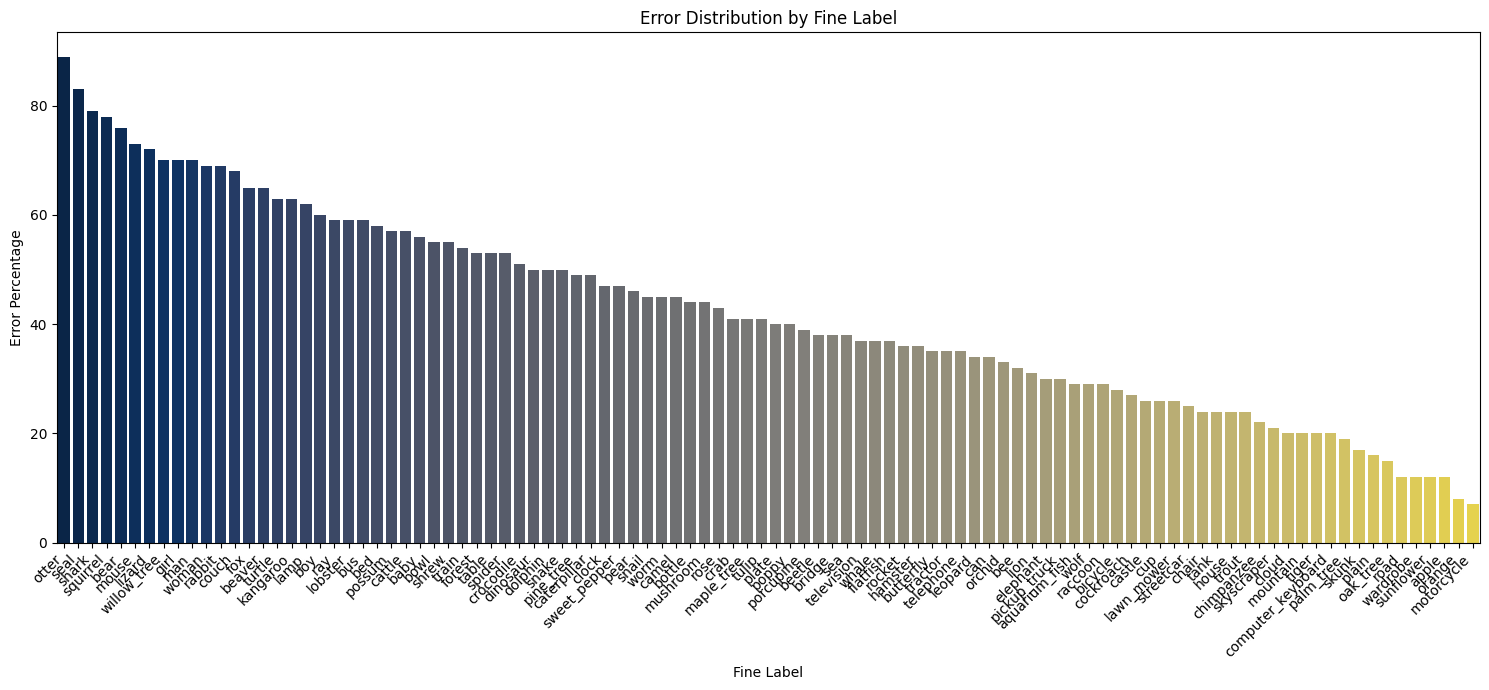

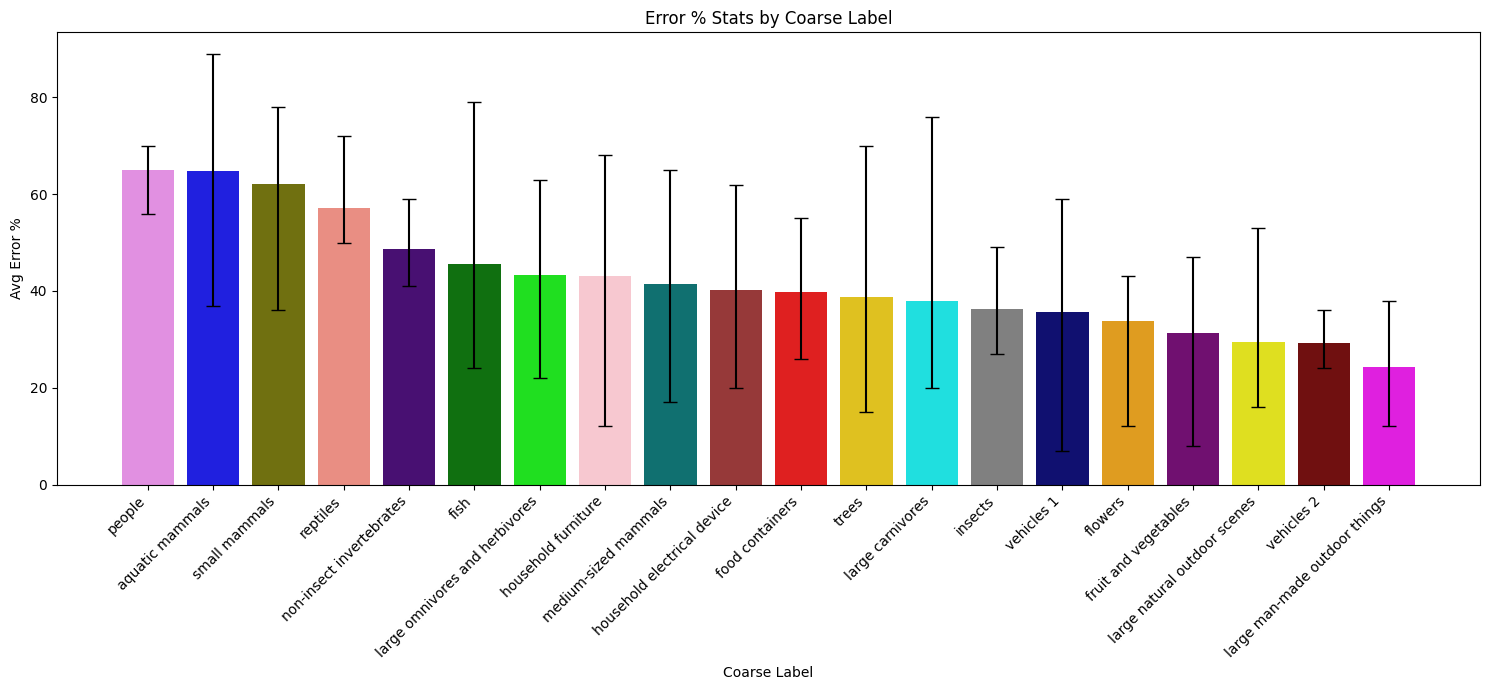

In [72]:
coarse_label_colors = {
    'aquatic mammals': 'blue',
    'fish': 'green',
    'flowers': 'orange',
    'food containers': 'red',
    'fruit and vegetables': 'purple',
    'household electrical device': 'brown',
    'household furniture': 'pink',
    'insects': 'gray',
    'large carnivores': 'cyan',
    'large man-made outdoor things': 'magenta',
    'large natural outdoor scenes': 'yellow',
    'large omnivores and herbivores': 'lime',
    'medium-sized mammals': 'teal',
    'non-insect invertebrates': 'indigo',
    'people': 'violet',
    'reptiles': 'salmon',
    'small mammals': 'olive',
    'trees': 'gold',
    'vehicles 1': 'navy',
    'vehicles 2': 'maroon',
}

# Error Distribution by Fine Label
plt.figure(figsize=(15, 7))
sns.barplot(x='Fine Label', y='Error', data=class_performance.sort_values(by='Error', ascending=False), palette='cividis')
plt.title('Error Distribution by Fine Label')
plt.xlabel('Fine Label')
plt.xticks(rotation=45, ha='right')  
plt.ylabel('Error Percentage')
plt.tight_layout()
plt.show()

# Calc min, mean, max error for each coarse label
error_stats = class_performance.groupby('Coarse Label')['Error'].agg(['mean', 'min', 'max']).reset_index().sort_values(by='mean', ascending=False)
error_stats['color'] = error_stats['Coarse Label'].map(coarse_label_colors)

# Error % Stats by Coarse Label
plt.figure(figsize=(15, 7))
sns.barplot(x='Coarse Label', y='mean', data=error_stats, order=error_stats['Coarse Label'], palette=error_stats['color'])
plt.errorbar(x=error_stats['Coarse Label'], y=error_stats['mean'],
             yerr=[error_stats['mean'] - error_stats['min'], error_stats['max'] - error_stats['mean']],
             fmt='none', color='black', capsize=5, zorder=5)  # zorder to bring error bars to the front
plt.title('Error % Stats by Coarse Label')
plt.xlabel('Coarse Label')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Avg Error %')
plt.tight_layout()
plt.show()

# Top & Bottom 5 Images for Error
Notice how the images that have the highest error all have very similar feature patterns, which is likely why the model has a hard time classifying them. On the other hand the images with the lowest error tend to have unique and consistant feature patterns.

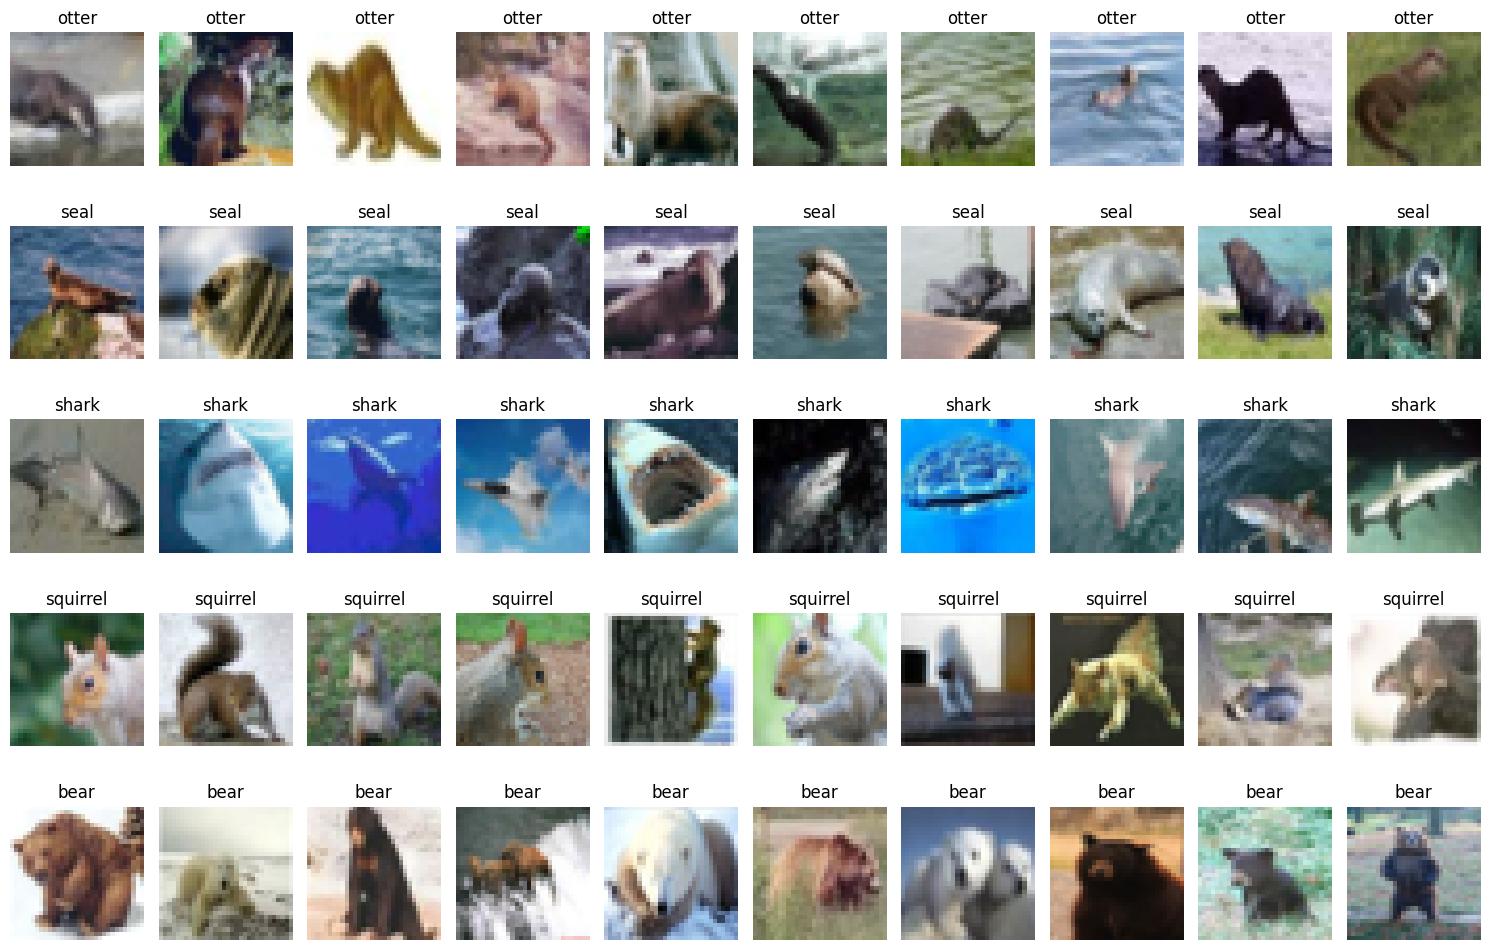

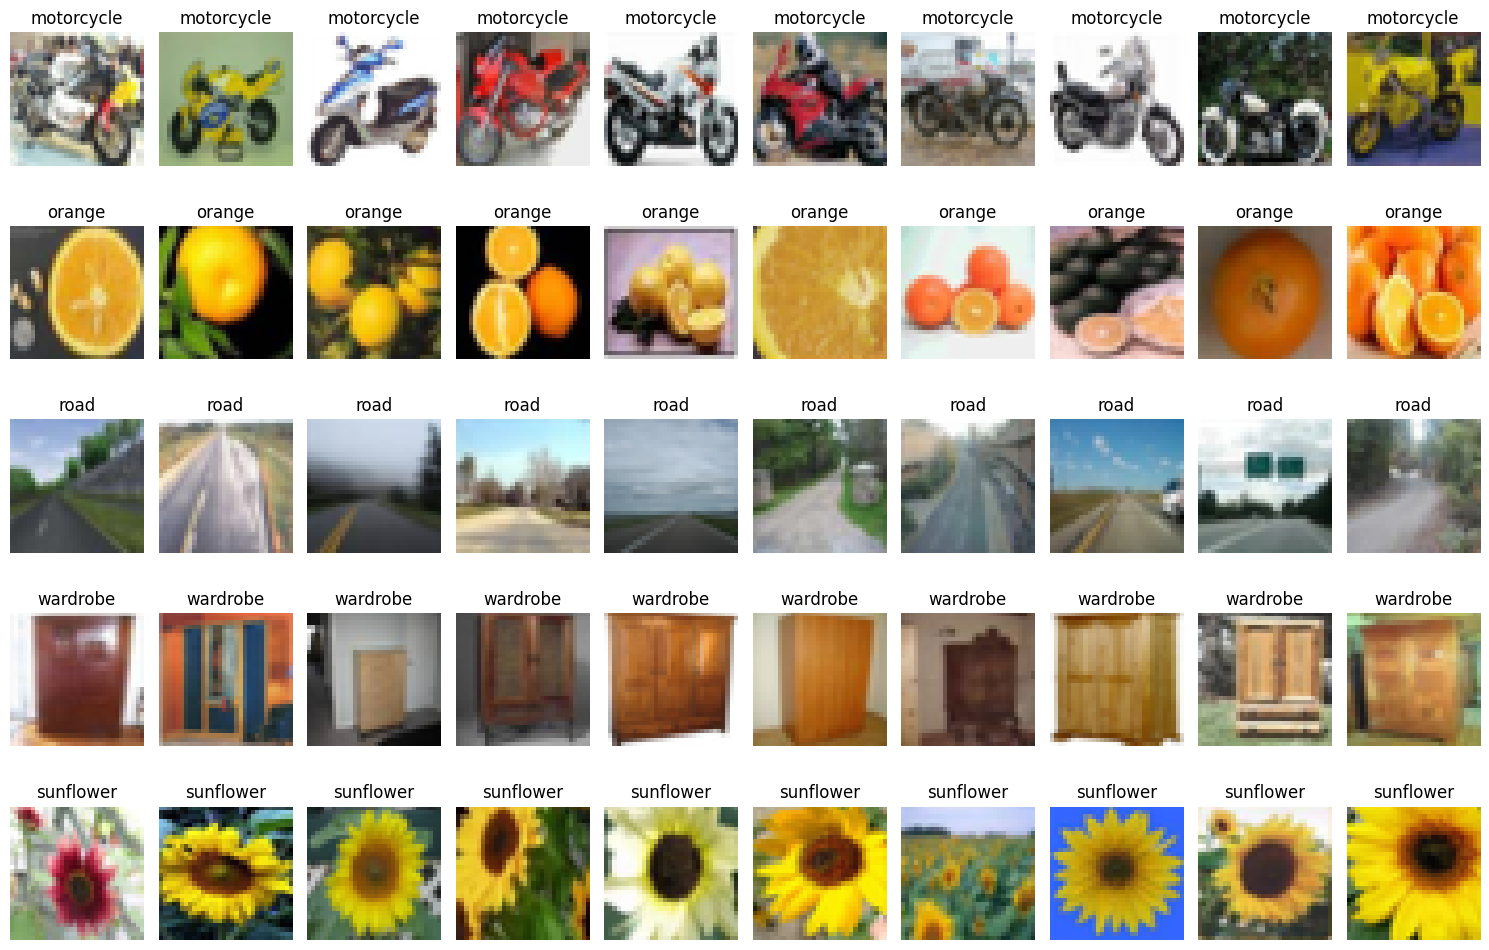

In [73]:
# Top 5 highest error images
highest_error_indices = class_performance.nlargest(5, 'Error').index.tolist()

images_to_visualize = []
for label_index in highest_error_indices:
    label_mask = y_true == label_index
    images_for_label = x_test[label_mask]
    images_to_visualize.append(images_for_label)

num_labels = len(highest_error_indices)
num_images_per_label = 10

plt.figure(figsize=(15, 10))

for i, label_index in enumerate(highest_error_indices):
    for j in range(num_images_per_label):
        plt.subplot(num_labels, num_images_per_label, i * num_images_per_label + j + 1)
        plt.imshow(images_to_visualize[i][j])
        plt.title(f"{fine_names[label_index]}")
        plt.axis('off')

plt.tight_layout()
plt.show()

# Top 5 lowest error images
lowest_error_indices = class_performance.nsmallest(5, 'Error').index.tolist()

images_to_visualize = []
for label_index in lowest_error_indices:
    label_mask = y_true == label_index
    images_for_label = x_test[label_mask]
    images_to_visualize.append(images_for_label)

num_labels = len(lowest_error_indices)
num_images_per_label = 10

plt.figure(figsize=(15, 10))

for i, label_index in enumerate(lowest_error_indices):
    for j in range(num_images_per_label):
        plt.subplot(num_labels, num_images_per_label, i * num_images_per_label + j + 1)
        plt.imshow(images_to_visualize[i][j])
        plt.title(f"{fine_names[label_index]}")
        plt.axis('off')

plt.tight_layout()
plt.show()

# Image Augmentation on High Error Images

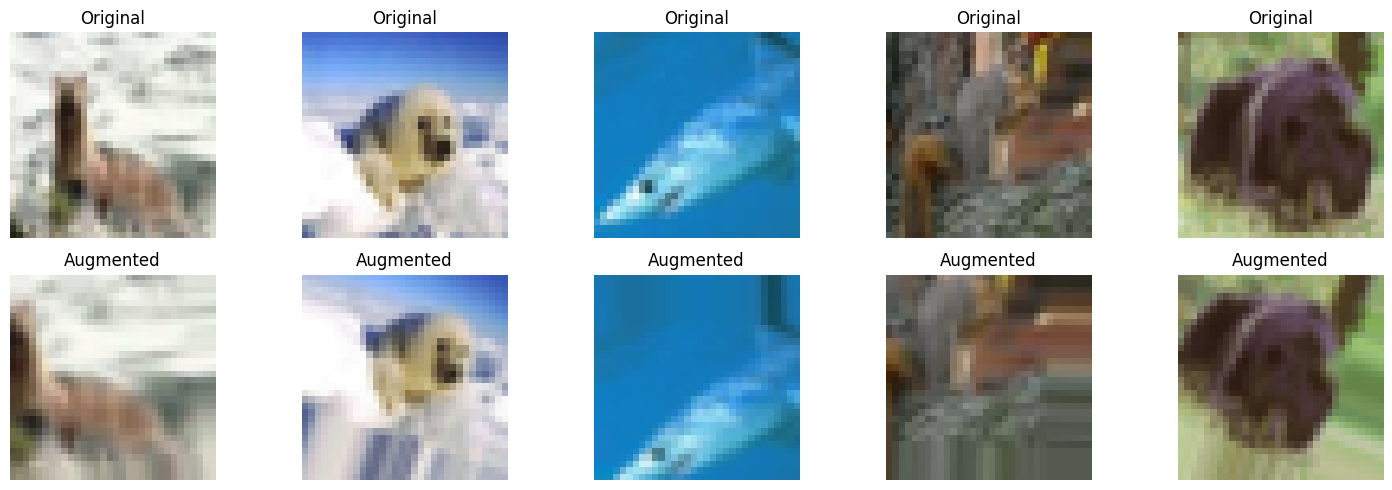

In [74]:
# Get an image from each class in the top 5 highest error classes
selected_images = []
for index in highest_error_indices:
    class_images = x_train[y_train[:, index] == 1][:1]
    selected_images.extend(class_images)

# Convert the selected images to a numpy array
selected_images = np.array(selected_images)

# Get a batch of augmented images
num_images = len(selected_images)
augmented_images, labels = next(datagen.flow(selected_images, np.zeros(num_images), batch_size=num_images, shuffle=False))

# Plot the original images on the top row and augmented images on the bottom row
plt.figure(figsize=(15, 5))
for i in range(num_images):
    # Plot original image on the top row
    plt.subplot(2, num_images, i + 1)
    plt.imshow(selected_images[i])
    plt.title('Original')
    plt.axis('off')

    # Plot augmented image on the bottom row
    plt.subplot(2, num_images, i + 1 + num_images)
    plt.imshow(augmented_images[i])
    plt.title('Augmented')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Model Performance Comparison

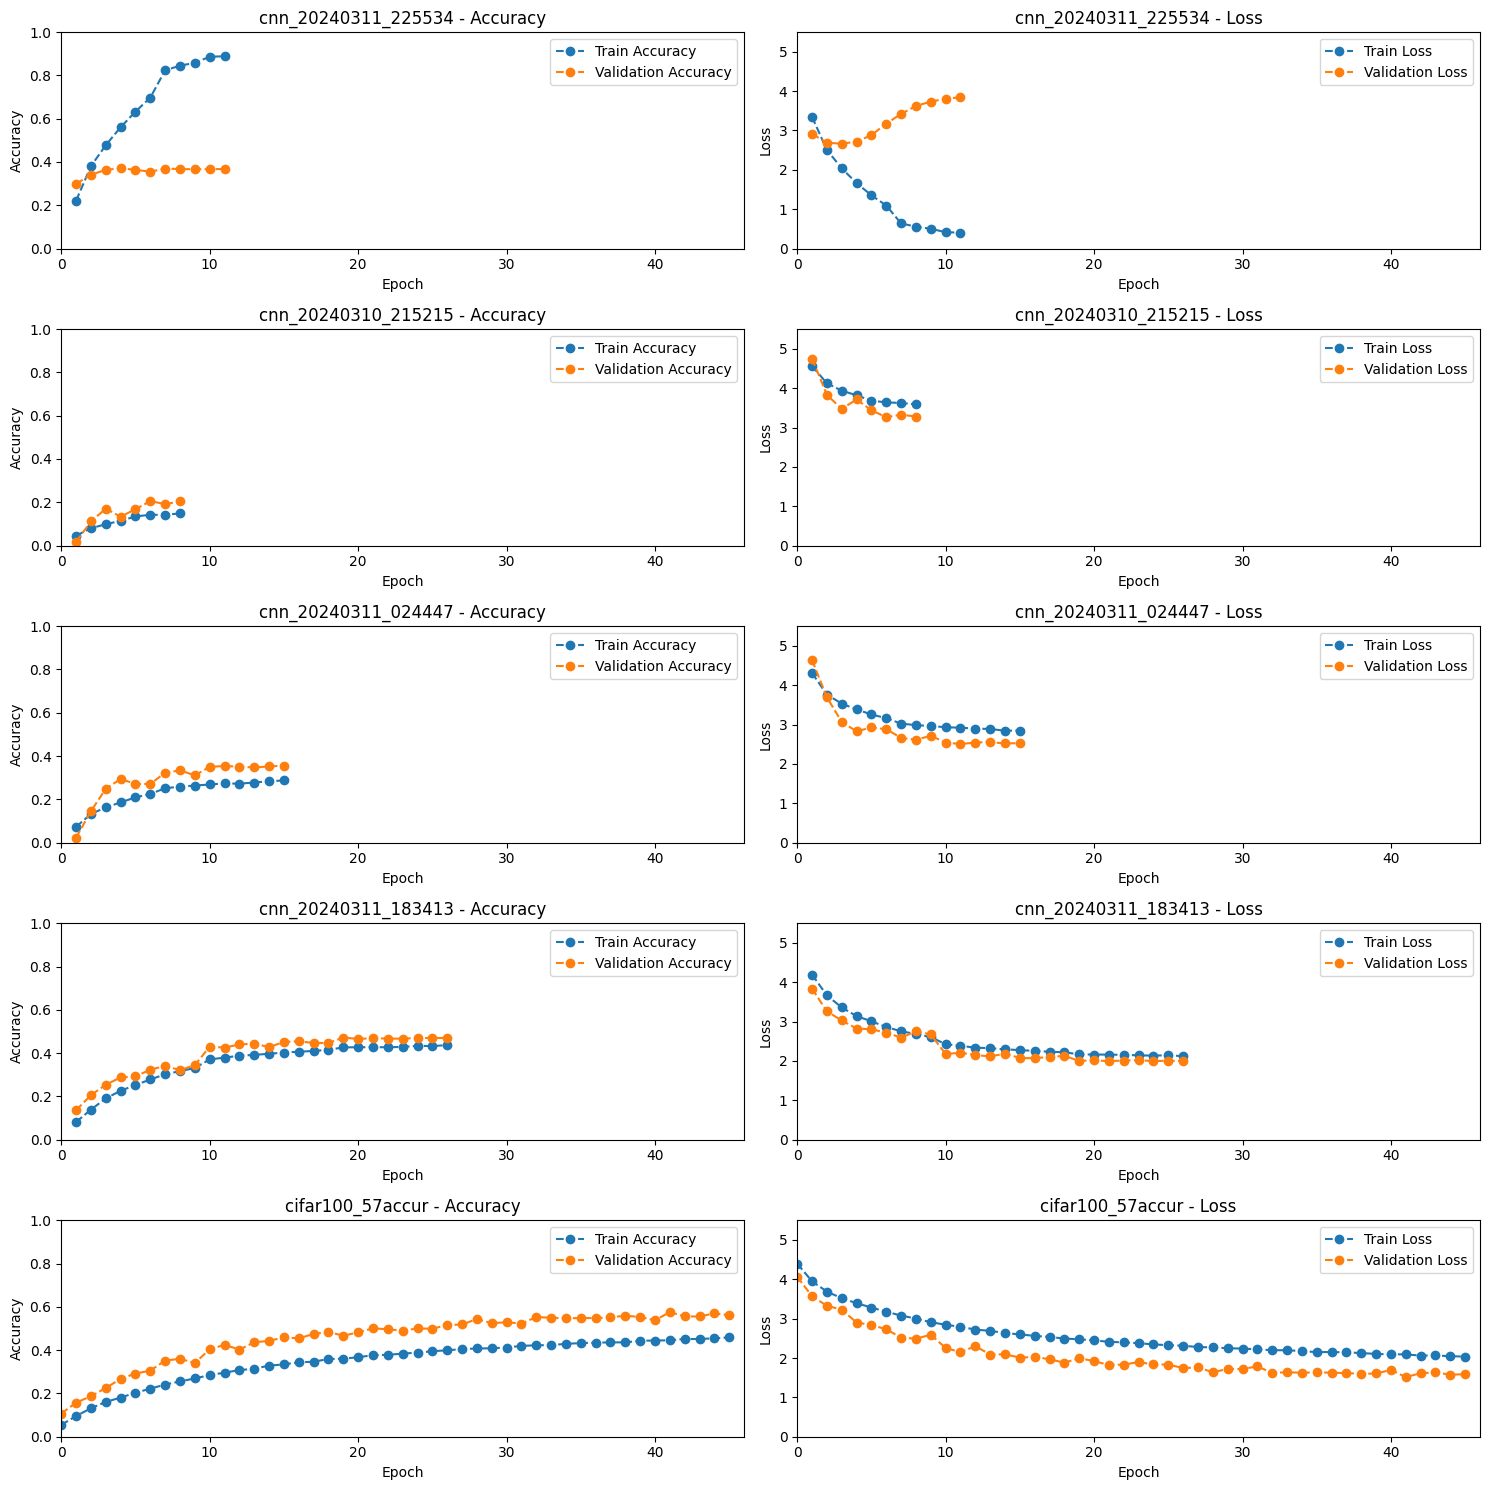

In [67]:
# Load the CSV data
model_performance = pd.read_csv('model_performance.csv')

# Define the list of models to include
selected_models = ['cnn_20240311_225534', 'cnn_20240310_215215', 'cnn_20240311_024447', 'cnn_20240311_183413', 'cifar100_57accur']
# selected_models = model_performance['model_id'].unique() #select all models

# Find the maximum number of epochs across all models
max_epochs = model_performance['epoch'].max() + 1

# Create subplots
fig, axs = plt.subplots(len(selected_models), 2, figsize=(15, 3 * len(selected_models)))


# Plot accuracy and loss for each model
for i, model_id in enumerate(selected_models):
    model_data = model_performance[model_performance['model_id'] == model_id]

    # Plot Accuracy
    axs[i, 0].plot(model_data['epoch'], model_data['accuracy'], label='Train Accuracy', linestyle='--', marker='o')
    axs[i, 0].plot(model_data['epoch'], model_data['val_accuracy'], label='Validation Accuracy', linestyle='--', marker='o')
    axs[i, 0].set_title(f'{model_id} - Accuracy')
    axs[i, 0].set_xlabel('Epoch')
    axs[i, 0].set_ylabel('Accuracy')
    axs[i, 0].set_ylim([0, 1])
    axs[i, 0].legend()

    # Plot Loss
    axs[i, 1].plot(model_data['epoch'], model_data['loss'], label='Train Loss', linestyle='--', marker='o')
    axs[i, 1].plot(model_data['epoch'], model_data['val_loss'], label='Validation Loss', linestyle='--', marker='o')
    axs[i, 1].set_title(f'{model_id} - Loss')
    axs[i, 1].set_xlabel('Epoch')
    axs[i, 1].set_ylabel('Loss')
    axs[i, 1].set_ylim([0, 5.5])
    axs[i, 1].legend()

    # Set x-axis limits to match the plot with the most epochs
    axs[i, 0].set_xlim([0, max_epochs])
    axs[i, 1].set_xlim([0, max_epochs])

# Adjust layout
plt.tight_layout()
plt.show()



In [70]:
# Load and display model summaries
for model in selected_models:
    get_model = load_model(f'../src/models/model_{model}.h5')
    print(model)
    get_model.summary()
    print('\n', '#' * 80, '\n') 

cnn_20240311_225534
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 30, 30, 64)        1792      
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 14, 14, 128)      0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 128)       0         
                                                                 
 flatten_9 (Flatten)         (None, 25088)             0         
                                                                 
 dense_9 (Dense)             (None, 100)               2508900   
                                 